<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-06-03 08:03:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.07s   

2021-06-03 08:03:25 (307 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

Lets plot some columns to underestand data better:

In [33]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



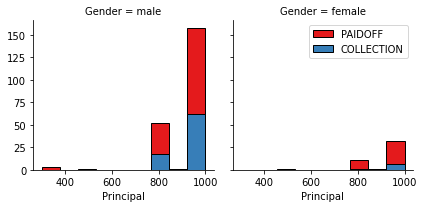

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

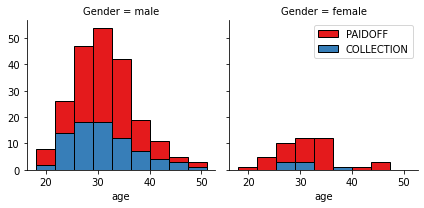

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

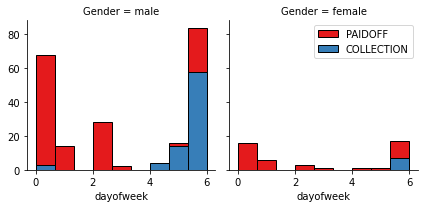

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [18]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [20]:
from sklearn.neighbors import KNeighborsClassifier
k = 5
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

In [21]:
yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [22]:
from sklearn import metrics

print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))

print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8152173913043478
Test set Accuracy:  0.7571428571428571


In [23]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

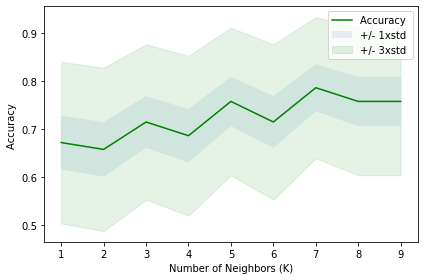

In [24]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [25]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


In [26]:
best_knn_model = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)
best_knn_model

KNeighborsClassifier(n_neighbors=7)

In [33]:
## Evaluation Metrics
# jaccard score and f1 score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

print("Train set Accuracy (Jaccard): ", jaccard_score(y_test, yhat,pos_label="PAIDOFF"))
print("Test set Accuracy (Jaccard): ", jaccard_score(y_test, yhat,pos_label="PAIDOFF"))
print("Train set Accuracy (F1): ", metrics.f1_score(y_train, best_knn_model.predict(X_train), average='weighted'))
print("Test set Accuracy (F1): ", metrics.f1_score(y_test, best_knn_model.predict(X_test), average='weighted'))

Train set Accuracy (Jaccard):  0.7384615384615385
Test set Accuracy (Jaccard):  0.7384615384615385
Train set Accuracy (F1):  0.8000194668761034
Test set Accuracy (F1):  0.7766540244416351


# Decision Tree

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [63]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.4, random_state=4)

In [81]:
mean_acc = np.zeros((9))

for d in range (1,10):
    drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = d).fit(X_trainset,y_trainset)
    drugTree_yhat = drugTree.predict(X_testset)
    print("For depth = {}  accuracy score is {} ".format(d, accuracy_score(y_testset, drugTree_yhat)))
    mean_acc[d-1] = accuracy_score(y_testset, drugTree_yhat)

For depth = 1  accuracy score is 0.7338129496402878 
For depth = 2  accuracy score is 0.7338129496402878 
For depth = 3  accuracy score is 0.7338129496402878 
For depth = 4  accuracy score is 0.7338129496402878 
For depth = 5  accuracy score is 0.7482014388489209 
For depth = 6  accuracy score is 0.7122302158273381 
For depth = 7  accuracy score is 0.6834532374100719 
For depth = 8  accuracy score is 0.6690647482014388 
For depth = 9  accuracy score is 0.6762589928057554 


In [84]:
print( "The best accuracy was with", mean_acc.max(), "with depth=", mean_acc.argmax()+1)

The best accuracy was with 0.7482014388489209 with depth= 5


In [85]:
drugTree_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5).fit(X_train, y_train)

In [91]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

print("Train set Accuracy (Jaccard): ", jaccard_score(y_test, yhat,pos_label="PAIDOFF"))
print("Test set Accuracy (Jaccard): ", jaccard_score(y_test, yhat,pos_label="PAIDOFF"))
print("Train set Accuracy (F1): ", f1_score(y_train, drugTree_model.predict(X_train), average='weighted'))
print("Test set Accuracy (F1): ", f1_score(y_test, drugTree_model.predict(X_test), average='weighted'))

Train set Accuracy (Jaccard):  0.7384615384615385
Test set Accuracy (Jaccard):  0.7384615384615385
Train set Accuracy (F1):  0.765101303824455
Test set Accuracy (F1):  0.6741854636591479


# Support Vector Machine

In [94]:
from sklearn import svm 
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

print ('Train set:', X_train.shape,  y_train.shape)

print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [120]:

for k in ('linear', 'poly', 'rbf','sigmoid'):
    svm_model = svm.SVC( kernel = k).fit(X_train,y_train)
    svm_yhat = svm_model.predict(X_test)
    print("For kernel: {}, the f1 score is: {}".format(k,f1_score(y_test,svm_yhat, average='weighted')))

For kernel: linear, the f1 score is: 0.6914285714285714
For kernel: poly, the f1 score is: 0.7064793130366899
For kernel: rbf, the f1 score is: 0.7275882012724117
For kernel: sigmoid, the f1 score is: 0.6892857142857144


In [97]:
clf = svm.SVC(kernel='rbf')

clf.fit(X_train, y_train) 

SVC()

In [98]:
yhat = clf.predict(X_test)

yhat [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [104]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

print("Train set Accuracy (Jaccard): ", jaccard_score(y_test, yhat,pos_label="PAIDOFF"))
print("Test set Accuracy (Jaccard): ", jaccard_score(y_test, yhat,pos_label="PAIDOFF"))
print("Train set Accuracy (F1): ", f1_score(y_train, clf.predict(X_train), average='weighted'))
print("Test set Accuracy (F1): ", f1_score(y_test, clf.predict(X_test), average='weighted'))

Train set Accuracy (Jaccard):  0.7272727272727273
Test set Accuracy (Jaccard):  0.7272727272727273
Train set Accuracy (F1):  0.7682165861513688
Test set Accuracy (F1):  0.7275882012724117


# Logistic Regression

In [122]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss
from sklearn import preprocessing


In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [124]:
for k in ('lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag'):
    lr_model = LogisticRegression(C = 0.01, solver = k).fit(X_train, y_train)
    lr_yhat = lr_model.predict(X_test)
    y_prob = lr_model.predict_proba(X_test)
    print('When Solver is {}, logloss is : {}'.format(k, log_loss(y_test, y_prob)))

When Solver is lbfgs, logloss is : 0.4920179847937498
When Solver is saga, logloss is : 0.49201867237854974
When Solver is liblinear, logloss is : 0.5772287609479654
When Solver is newton-cg, logloss is : 0.4920178014679269
When Solver is sag, logloss is : 0.49201648132933784


In [125]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

In [126]:
yhat = LR.predict(X_test)
yhat[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [128]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

print("Train set Accuracy (Jaccard): ", jaccard_score(y_test, yhat,pos_label="PAIDOFF"))
print("Test set Accuracy (Jaccard): ", jaccard_score(y_test, yhat,pos_label="PAIDOFF"))
print("Train set Accuracy (F1): ", f1_score(y_train, LR.predict(X_train), average='weighted'))
print("Test set Accuracy (F1): ", f1_score(y_test, LR.predict(X_test), average='weighted'))

Train set Accuracy (Jaccard):  0.6764705882352942
Test set Accuracy (Jaccard):  0.6764705882352942
Train set Accuracy (F1):  0.7341146337750953
Test set Accuracy (F1):  0.6670522459996144


In [132]:
yhat_prob = LR.predict_proba(X_test)

In [131]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.5772287609479654

# Model Evaluation using Test set

In [164]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [134]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-06-03 09:37:35--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-06-03 09:37:36 (115 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [135]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [168]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek


Feature1 = test_df[['Principal','terms','age','Gender','weekend']]
Feature1 = pd.concat([Feature1,pd.get_dummies(test_df['education'])], axis=1)
Feature1.drop(['Master or Above'], axis = 1,inplace=True)


x_loan_test = Feature1
x_loan_test = preprocessing.StandardScaler().fit(x_loan_test).transform(x_loan_test)

y_loan_test = test_df['loan_status'].values

In [174]:
# KNN

              
knn_yhat = best_knn_model.predict(x_loan_test)
jacc1 = jaccard_score(y_loan_test, knn_yhat,pos_label="PAIDOFF")
jacc1

0.6538461538461539

In [175]:

# Decision Tree
dt_yhat = drugTree_model.predict(x_loan_test)
jacc2 = jaccard_score(y_loan_test, dt_yhat,pos_label="PAIDOFF")
jacc2

0.6904761904761905

In [176]:
# Support Vector Machine
svm_yhat = clf.predict(x_loan_test)
jacc3 = jaccard_score(y_loan_test, svm_yhat,pos_label="PAIDOFF")
jacc3

0.78

In [177]:
# Logistic Regression
lr_yhat = LR.predict(x_loan_test)
jacc4 = jaccard_score(y_loan_test, lr_yhat,pos_label="PAIDOFF")
jacc4

0.7358490566037735

In [178]:
jss = [jacc1, jacc2, jacc3, jacc4]
jss

[0.6538461538461539, 0.6904761904761905, 0.78, 0.7358490566037735]

In [154]:
# F1_score

# KNN
knn_yhat = best_knn_model.predict(x_loan_test)
f1 = round(f1_score(y_loan_test, knn_yhat, average = 'weighted'), 2)
f1

0.63

In [156]:
# Decision Tree
dt_yhat = drugTree_model.predict(x_loan_test)
f2 = round(f1_score(y_loan_test, dt_yhat, average = 'weighted'), 2)
f2

0.77

In [157]:
# Support Vector Machine
svm_yhat = clf.predict(x_loan_test)
f3 = round(f1_score(y_loan_test, svm_yhat, average = 'weighted'), 2)
f3

0.76

In [159]:
# Logistic Regression
lr_yhat = LR.predict(x_loan_test)
f4 = round(f1_score(y_loan_test, lr_yhat, average = 'weighted'), 2)
f4

0.66

In [160]:
f1_list = [f1, f2, f3, f4]
f1_list

[0.63, 0.77, 0.76, 0.66]

In [161]:
# log loss

# Logistic Regression
lr_prob = LR.predict_proba(x_loan_test)
ll_list = ['NA','NA','NA', round(log_loss(y_loan_test, lr_prob), 2)]
ll_list

['NA', 'NA', 'NA', 0.57]

In [179]:
columns = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
index = ['Jaccard', 'F1-score', 'Logloss']

accuracy_df = pd.DataFrame([jss, f1_list, ll_list], index = index, columns = columns)
accuracy_df1 = accuracy_df.transpose()
accuracy_df1.columns.name = 'Algorithm'
accuracy_df1

Algorithm,Jaccard,F1-score,Logloss
KNN,0.653846,0.63,NA
Decision Tree,0.690476,0.77,NA
SVM,0.78,0.76,NA
Logistic Regression,0.735849,0.66,0.57


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>